# MIMIC-III M3Care Baseline

### Initialize Datasets

In [1]:
from pathlib import Path
import torch

from mimic.datasets.mimic import MimicDataset

PROCESSED_DIR = Path('./mimic/data/processed')

train_dataset_paths = {
    'demographic': PROCESSED_DIR / 'train/demographic.csv',
    'vitals': PROCESSED_DIR / 'train/vitals.csv',
    'interventions': PROCESSED_DIR / 'train/interventions.csv',
    'static_notes': PROCESSED_DIR / 'train/static_notes_bert.h5',
    'ts_notes': PROCESSED_DIR / 'train/ts_notes_bert.h5',
    'labels': PROCESSED_DIR / 'train/labels.csv'
}

test_dataset_paths = {
    'demographic': PROCESSED_DIR / 'test/demographic.csv',
    'vitals': PROCESSED_DIR / 'test/vitals.csv',
    'interventions': PROCESSED_DIR / 'test/interventions.csv',
    'static_notes': PROCESSED_DIR / 'test/static_notes_bert.h5',
    'ts_notes': PROCESSED_DIR / 'test/ts_notes_bert.h5',
    'labels': PROCESSED_DIR / 'test/labels.csv'
}

train_auxillary_paths = {
    'pat_ids': PROCESSED_DIR / 'train_idxs.npy',
}

test_auxillary_paths = {
    'pat_ids': PROCESSED_DIR / 'test_idxs.npy',
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = MimicDataset(train_dataset_paths, train_auxillary_paths, device)
test_ds = MimicDataset(test_dataset_paths, test_auxillary_paths, device)

### Initialize Unimodal Models

In [2]:
from m3care.m3care import Modal, M3Care

EMB_DIM = 512
OUT_DIM = 2
DROPOUT = 0.3

DEM_INPUT = 18

VIT_INPUT = 104
VIT_TIME_DIM = 150

ITV_INPUT = 14
ITV_TIME_DIM = 150

NOTES_TOK_DIM = 16
NOTES_VOCAB_SIZE = 5000
NOTES_NUM_HEADS = 8

NST_INPUT = 768
NST_WORD_LIM = 10000

NTS_INPUT = 782
NTS_TIME_DIM = 128
NTS_WORD_LIM = 5000

In [3]:
from mimic.models.vector import MLP
from mimic.models.sequential import SequentialEmbedder

dem_model = MLP(in_dim=DEM_INPUT,
                hidden_dim=[128,192,256],
                out_dim=EMB_DIM, 
                bias=True,
                relu=True,
                norm=True)

vit_model = SequentialEmbedder(feat_dim=VIT_INPUT,
                             embed_dim=EMB_DIM,
                             max_len=VIT_TIME_DIM,
                             dropout=DROPOUT)

itv_model = SequentialEmbedder(feat_dim=ITV_INPUT,
                             embed_dim=EMB_DIM,
                             max_len=ITV_TIME_DIM,
                             dropout=DROPOUT)

nst_model = MLP(in_dim=NST_INPUT,
                hidden_dim=[1024, 768, 512],
                out_dim=EMB_DIM,
                bias=True,
                relu=True,
                norm=True)

nts_model = SequentialEmbedder(feat_dim=NTS_INPUT,
                               embed_dim=EMB_DIM,
                               max_len=NTS_TIME_DIM,
                               dropout=DROPOUT,
                               mlp_hidden=[1024, 768, 512])

## Training Setup

In [4]:
import torch

KFOLDS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
EPOCHS = 5
UPDATE_FREQ = 10

Initalize data loaders

In [5]:
from util.kfold import KFoldDatasetLoader

train_loader = KFoldDatasetLoader(train_ds, KFOLDS, BATCH_SIZE)
test_loader = KFoldDatasetLoader(test_ds, KFOLDS, BATCH_SIZE)

Initialize model

In [6]:
modals = [
    Modal('demographic', dem_model, False, None),   
    Modal('vitals', vit_model, True, VIT_TIME_DIM),
    Modal('interventions', itv_model, True, ITV_TIME_DIM),
    Modal('static_notes', nst_model, True, None),
    Modal('ts_notes', nts_model, True, NTS_TIME_DIM)
]

model = M3Care(modals, EMB_DIM, OUT_DIM, device).to(device)

Loss function

In [7]:
loss_fn = torch.nn.BCEWithLogitsLoss()

Optimizer

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training Loop

In [9]:
grads_in, grads_out = [], []
def save_grad_hook(module, grad_input, grad_output):
    grads_in.append(grad_input)
    grads_out.append(grad_output)
model.mm_tran.register_full_backward_hook(save_grad_hook)

In [10]:
from torch.utils import tensorboard as tb
from math import ceil

def batches_per_epoch(loader: KFoldDatasetLoader):
    batch_per_fold = [ceil(sz/loader.batch_size) for sz in loader.fold_sizes]
    train_batches = sum([b * (loader.kfolds-1) for b in batch_per_fold])
    val_batches = sum(batch_per_fold)
    return train_batches, val_batches


def train_one_epoch(epoch_idx: int, writer: tb.SummaryWriter):
    running_loss = 0
    last_train_loss = 0
    last_val_loss = 0

    cnt_train_batches, cnt_val_batches = batches_per_epoch(train_loader)

    # Loop through each set of kfolds
    while not train_loader.end:
        train_loader.train()

        batch_cnt = 0
        # Loop through each training batch
        while not train_loader.train_round_end:
            (batch, mask), batch_size = train_loader.next_batch()
            labels = batch['labels']

            optimizer.zero_grad()

            pred, l_stab = model(batch, mask, batch_size)
            loss = loss_fn(pred, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            
            if batch_cnt % UPDATE_FREQ == UPDATE_FREQ-1:
                last_train_loss = running_loss / UPDATE_FREQ
                print(f'\tbatch {batch_cnt} loss: {last_train_loss}')
                tb_x = epoch_idx * cnt_train_batches + batch_cnt + 1
                writer.add_scalar('Loss/train', last_train_loss, tb_x)
                writer.flush()
                running_loss = 0

            batch_cnt += 1

        train_loader.val()
        model.eval()

        batch_cnt = 0
        running_loss = 0
        # Loop through each validation batch
        while not train_loader.val_round_end:
            (batch, mask), batch_size = train_loader.next_batch()
            labels = batch['labels']

            with torch.no_grad():
                pred, l_stab = model(batch, mask, batch_size)
                loss = loss_fn(pred, labels)

            running_loss += loss.item()
            batch_cnt += 1

        last_val_loss = running_loss / batch_cnt
        print(f'LOSS train {last_train_loss} val {last_val_loss}')
        writer.add_scalars('Training vs. Validation Loss', {'Training': last_train_loss, 'Validation': last_val_loss}, epoch_idx+1)
        writer.flush()

    train_loader.reset()

    return last_train_loss, last_val_loss

In [11]:
from datetime import datetime
from torch.utils import tensorboard as tb
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = tb.SummaryWriter(f'runs/mimic_trainer_{timestamp}')

best_loss = 1e10
torch.autograd.set_detect_anomaly(True)
for epoch in range(EPOCHS):
    print(f"EPOCH {epoch}:")

    model.train(True)
    train_loss, val_loss = train_one_epoch(epoch, writer)

    if val_loss < best_loss:
        best_loss = val_loss
        model_path = f'modal_{timestamp}_{epoch}'
        torch.save(model.state_dict(), model_path)

EPOCH 0:


c:\Users\Jason\Work\M3Care\env\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


	batch 9 loss: 0.6365278080105782
	batch 19 loss: 0.456787084043026
	batch 29 loss: 0.353036367893219
	batch 39 loss: 0.28532465547323227
	batch 49 loss: 0.3225106790661812
	batch 59 loss: 0.28985789865255357
	batch 69 loss: 0.28094961419701575
	batch 79 loss: 0.4729249894618988
	batch 89 loss: 0.3185030981898308
	batch 99 loss: 0.2772203370928764
	batch 109 loss: 0.28164172321558
	batch 119 loss: 0.25359625816345216
	batch 129 loss: 0.2911166101694107
	batch 139 loss: 0.23719280809164048
	batch 149 loss: 0.23426753059029579
	batch 159 loss: 0.2514107085764408
	batch 169 loss: 0.28503173142671584
	batch 179 loss: 0.2600777752697468
	batch 189 loss: 0.30453898310661315


c:\Users\Jason\Work\M3Care\env\lib\site-packages\torch\autograd\graph.py:768: UserWarning: Error detected in ScaledDotProductEfficientAttentionBackward0. Traceback of forward call that caused the error:
  File "C:\Users\Jason\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Jason\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\Jason\Work\M3Care\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Jason\Work\M3Care\env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Jason\Work\M3Care\env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\Jason\Work\M3Care\env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.a

RuntimeError: Function 'ScaledDotProductEfficientAttentionBackward0' returned nan values in its 0th output.

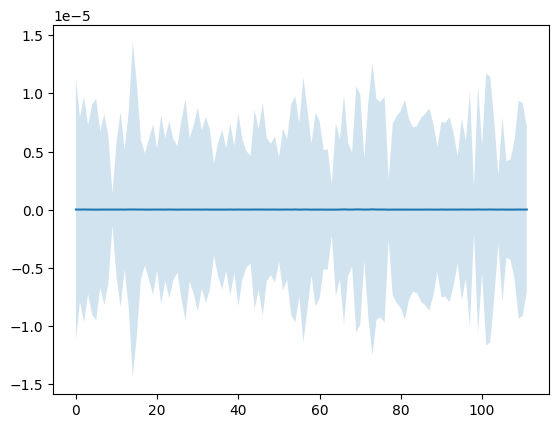

In [ ]:
from matplotlib import pyplot as plt

def plot_grads(grads, idx=0):
    means = torch.tensor([grad[idx].mean().item() for grad in grads])
    stds = torch.tensor([grad[idx].std().item() for grad in grads])
    x = torch.arange(len(means))
    plt.plot(x, means)
    plt.fill_between(x, means+stds, means-stds, alpha=0.2)

plot_grads(grads_in)


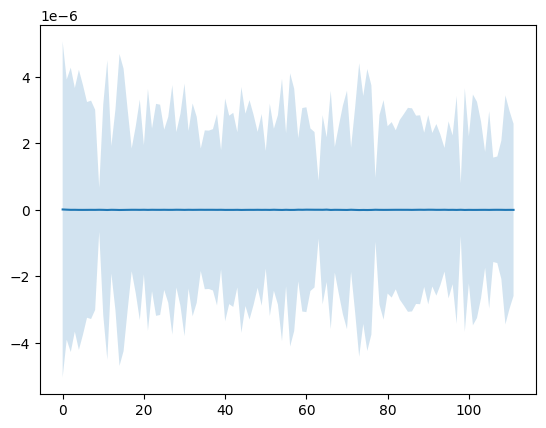

In [ ]:
plot_grads(grads_out)